In [1]:
%matplotlib inline
import datascrape as ds
from datetime import date
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('data/KBOS-2012.csv')

In [3]:
df.columns

Index(['EST', 'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles', ' Min VisibilityMiles',
       ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH', ' Max Gust SpeedMPH',
       'PrecipitationIn', ' CloudCover', ' Events', ' WindDirDegrees'],
      dtype='object')

In [4]:
# All data
dd = ds.dictdf(ds.munis, date(1960, 1, 1), date(2015, 12, 31))

### Preprocessing the data
We quantize the measured precipitation in inches into the following buckets:

0 - 0.02 (No rain)

0.02 - 0.065

0.065 - 0.15

0.15 - 0.3

0.3 - 0.6

\> 0.6

In [5]:
num_measurements = len(dd["KBOS"])
rain_measurements = np.zeros(num_measurements*len(dd))
for ii, muni in enumerate(dd):
    rain_measurements[ii*num_measurements:(ii+1)*num_measurements] = dd[muni].PrecipitationIn.values

[0, 3, 0, 67330.0]

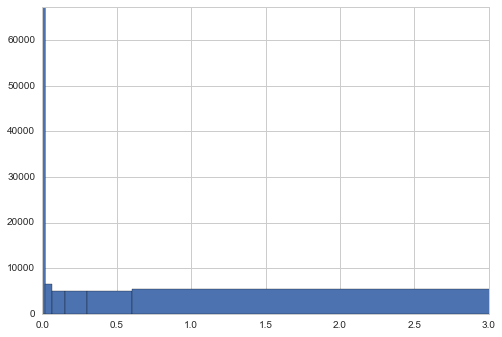

In [6]:
# hardcode bins to make each bin roughly equal in size
bins = [0.0, 0.02, 0.065, .15, .3, .6, 60]
n, bins, patches = plt.hist(rain_measurements, bins=bins)
plt.axis([0, 3, 0, max(n)])

In [7]:
# get dictionary from muni -> df to just muni -> rain measurements and muni -> discrete levels
rain_discrete = {}
rain_measure = {}
for muni in dd:
    rain_measure[muni] = dd[muni].PrecipitationIn.values
    rain_discrete[muni] = np.digitize(dd[muni].PrecipitationIn.values, bins)

In [8]:
# helper function for k2, given some dictionary of municipality -> precip bucket
# counts number of instances in the dataset
def num_instances(muni_dict):
    instances = 0
    for idx in range(num_measurements):
        isInstance = True
        for muni in muni_dict:
            if rain_discrete[muni][idx] != muni_dict[muni]:
                isInstance = False
                break
        if isInstance:
            instances += 1
    return instances

# helper function for k2, calculate probability of some municipality and list of parents
def log_probability(muni, parents):
    p = 0
    permutations = product(range(len(bins)), repeat=len(parents))
    for permutation in permutations:
        total_instances = 0
        muni_dict = dict(zip(parents, list(permutation)))
        for k in range(len(bins)):
            muni_dict[muni] = k
            instances = num_instances(muni_dict)
            total_instances += instances
            p += np.sum(list(map(lambda x: np.log(x), range(1, instances))))
        p += np.sum(list(map(lambda x: np.log(x), range(1, len(bins) - 1))))
        p -= np.sum(list(map(lambda x: np.log(x), range(1, total_instances + len(bins) - 1))))
    return p

merge here

#### get ordering of nodes based on some measure

In [9]:
# create ordering dictionary (asc)
ord_dict = {}

for key1 in ds.munis.keys():
    ord_dict[key1] = []
    for key2 in ds.munis.keys():
        if key1 == key2:
            continue
        ord_dict[key1].append( (np.corrcoef(rain_measure[key1], rain_measure[key2])[1][0], key2) )
    # sort desc after closeness of ordering
    ord_dict[key1] = sorted(ord_dict[key1], key=lambda tup: -tup[0])

In [10]:
ord_dict

{'KBAF': [(0.64296597810727019, 'KOWD'),
  (0.62281029948792288, 'KPSF'),
  (0.58648514204385271, 'KORH'),
  (0.55418981955925828, 'KBED'),
  (0.53103930303250102, 'KLWM'),
  (0.50859596495362447, 'KPYM'),
  (0.49439229602348106, 'KEWB'),
  (0.45920264194886218, 'KBOS'),
  (0.25389866057367216, 'KCEF')],
 'KBED': [(0.66091779568761466, 'KOWD'),
  (0.65004337814328439, 'KLWM'),
  (0.6219299054451588, 'KBOS'),
  (0.61607105408308382, 'KORH'),
  (0.5773069254725961, 'KEWB'),
  (0.55418981955925828, 'KBAF'),
  (0.54566132291312952, 'KPYM'),
  (0.49536763570352943, 'KPSF'),
  (0.24045370499339075, 'KCEF')],
 'KBOS': [(0.68215568742883859, 'KORH'),
  (0.67747732313717102, 'KLWM'),
  (0.6219299054451588, 'KBED'),
  (0.59748133016225091, 'KPYM'),
  (0.58911980101381334, 'KOWD'),
  (0.56681598294955027, 'KEWB'),
  (0.45920264194886212, 'KBAF'),
  (0.41118321993769319, 'KPSF'),
  (0.19878199994182918, 'KCEF')],
 'KCEF': [(0.26609608630334802, 'KORH'),
  (0.25389866057367216, 'KBAF'),
  (0.240453

In [90]:
dfgeo = pd.read_csv('data/geoinfo.tsv', sep='\t')
dfgeo.set_index('name', inplace=True)
dfmunis = pd.DataFrame(list(ds.munis.items()), columns=['code', 'name'])
dfmunis.set_index('name', inplace=True)

dfjoined = dfmunis.join(dfgeo)
dfjoined.reset_index(inplace=True)
dfjoined

,name,code,lat,lon
0,Carver,KPYM,41.91,70.73
1,Lawrence,KLWM,42.72,71.12
2,Norwood,KOWD,42.18,71.18
3,Pittsfield,KPSF,42.26,73.18
4,Chicopee,KCEF,42.20,72.53
5,Boston,KBOS,42.37,71.03
6,Westfield,KBAF,42.17,72.72
7,Worcester,KORH,42.27,71.87
8,Bedford,KBED,42.47,71.28
9,New Bedford,KEWB,41.68,70.97


In [127]:
# produce ordering using a minimum spanning tree based on distance as edge weights
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree

X = dfjoined[['lon', 'lat']].values
# use 6 nearest neighbors to generate preliminary graph
G = kneighbors_graph(X, n_neighbors=6, mode='distance')
# compute the minimum spanning tree of this graph
T = minimum_spanning_tree(G, overwrite=True)
# retrieve coordinates
T = T.tocoo()

dist = T.data
p1 = T.row
p2 = T.col
A = X[p1].T
B = X[p2].T
lon_coords = np.vstack([A[0], B[0]])
lat_coords = np.vstack([A[1], B[1]])

In [129]:
lon_coords.shape

(2, 9)

In [146]:
def plot_map_mst(lon_coords, lat_coords, order=None):
    
    def plot_mst(map, lon_coords, lat_coords):
        assert(lon_coords.shape == lat_coords.shape)
        for i in range(lon_coords.shape[1]):
            lons = -np.array([lon_coords[0, i], lon_coords[1, i]])
            lats = np.array([lat_coords[0, i], lat_coords[1, i]])

            x, y = map(lons, lats)

            dx = x[1] - x[0]
            dy = y[1] - y[0]
            plt.arrow(x[0] + coeff_cut * 0.5 * dx, y[0] + coeff_cut * 0.5 * dy, \
                      (1.0 - coeff_cut)* dx, (1.0 - coeff_cut) * dy,\
                      shape='full', lw=1.35, length_includes_head=True, head_width=.0,\
                      fc=arrow_color, ec=arrow_color, zorder=25)

    water_color=sns.xkcd_rgb["baby blue"]
    land_color=sns.xkcd_rgb["beige"]
    marker_color=sns.xkcd_rgb["chocolate brown"]
    arrow_color=sns.xkcd_rgb["dull red"]

    map = Basemap(llcrnrlon=-73.6,llcrnrlat=41.25,urcrnrlon=-69.75,urcrnrlat=43, resolution = 'h')
    map.drawstates(color='white', linewidth=2)
    map.drawmapboundary(fill_color=water_color)
    map.fillcontinents(color=land_color,lake_color=water_color)
    map.drawrivers(color=water_color, zorder=-1)

    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    for label, xpt, ypt in zip(labels, x, y):
        #manual positioning fix
        if label == 'Westfield':
            plt.text(xpt+2*offset, ypt-3*offset, label, zorder=30)
        else:  
            plt.text(xpt+offset, ypt+offset, label,zorder=30)
    plot_mst(map, lon_coords, lat_coords)

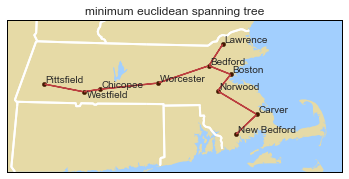

In [147]:
plot_map_mst(lon_coords, lat_coords)
plt.title('minimum euclidean spanning tree')

In [148]:
adj_matrix = T.toarray()

In [149]:
from enum import Enum
class Color(Enum):
    GRAY = 1 # next to visit
    WHITE = 0 # non-visited
    BLACK = 2 # visited
# determine an ordering from a MST via some tree search (choose BFS here)
num_nodes = adj_matrix.shape[0]
colors = np.array([Color.WHITE] * num_nodes)
# some start node (here the first one --> let the user choose this one)
start_node = 0
order = []
colors[start_node] = Color.GRAY
order.append(start_node) # whenever something is GRAYED add to order...
queue = []
queue.append(start_node)
while len(queue) > 0:
    #dequeue
    u = queue[0]
    queue = queue[1:]
    
    for v in range(num_nodes):
        #adjacent ?
        if adj_matrix[u, v] > 0 or adj_matrix[v, u] > 0:
            if colors[v] == Color.WHITE: # not visited yet?
                colors[v] = Color.GRAY
                order.append(v)
                queue.append(v)
#         dequeue?
#         queue = queue[1:]
    colors[u] = Color.BLACK

In [150]:
order

[0, 2, 9, 5, 8, 1, 7, 4, 6, 3]

In [155]:
def plot_map_order(order):

    water_color=sns.xkcd_rgb["baby blue"]
    land_color=sns.xkcd_rgb["beige"]
    marker_color=sns.xkcd_rgb["chocolate brown"]
    arrow_color=sns.xkcd_rgb["dull red"]

    map = Basemap(llcrnrlon=-73.6,llcrnrlat=41.25,urcrnrlon=-69.75,urcrnrlat=43, resolution = 'h')
    map.drawstates(color='white', linewidth=2)
    map.drawmapboundary(fill_color=water_color)
    map.fillcontinents(color=land_color,lake_color=water_color)
    map.drawrivers(color=water_color, zorder=-1)

    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    pos = 1
    for i in order:
        label, xpt, ypt = labels[i], x[i], y[i]
        #manual positioning fix
        if label == 'Westfield':
            label = ''
            plt.text(xpt+2*offset, ypt-3*offset, label + ' ({})'.format(pos), zorder=30)
        else:  
            label = ''
            plt.text(xpt+offset, ypt+offset, label + ' ({})'.format(pos),zorder=30)
        pos += 1

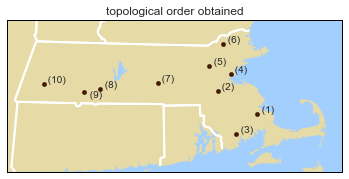

In [156]:
plot_map_order(order)
plt.title('topological order obtained')

In [109]:
# base ordering on geographical distance (euclidean norm)
# choose as first node the most western node (i.e. min lon)
# choose as next node iteratively the closest one

# old std based one
# node_ordering = []
# for key in ds.munis.keys():
#     node_ordering.append( (rain_measure[key].std(), key) )
# node_ordering = sorted(node_ordering, key=lambda tup: -tup[0])

node_ordering = []
for key in ds.munis.keys():
    row = dfjoined[dfjoined['code'] == key]
    node_ordering.append((row['lon'].values[0], key))
node_ordering = sorted(node_ordering, key=lambda tup: -tup[0])
node_ordering = [node_ordering[0][1]]

remaining_codes = set(dfjoined['code'].values) - set(node_ordering)
while len(remaining_codes) > 0:
    last_node = node_ordering[-1]
    row = dfjoined[dfjoined['code'] == last_node]
    lonn = row['lon'].values[0]
    latn = row['lat'].values[0]
    distances = []
    codes = []
    for code in remaining_codes:
        row = dfjoined[dfjoined['code'] == code]
        lon = row['lon'].values[0]
        lat = row['lat'].values[0]
        distances.append((lonn - lon)**2 + (latn - lat)**2)
        codes.append(code)
        
    imin = np.argmin(np.array(distances))
    node_ordering.append(codes[imin])
    
    remaining_codes = set(dfjoined['code'].values) - set(node_ordering)

In [110]:
node_ordering

['KPSF',
 'KBAF',
 'KCEF',
 'KORH',
 'KBED',
 'KBOS',
 'KOWD',
 'KPYM',
 'KEWB',
 'KLWM']

In [111]:
ord_relation ={}
for i in range(len(node_ordering) - 1):
    ord_relation[node_ordering[i+1]] = [node_ordering[i]]
ord_relation

{'KBAF': ['KPSF'],
 'KBED': ['KORH'],
 'KBOS': ['KBED'],
 'KCEF': ['KBAF'],
 'KEWB': ['KPYM'],
 'KLWM': ['KEWB'],
 'KORH': ['KCEF'],
 'KOWD': ['KBOS'],
 'KPYM': ['KOWD']}

merge end

pebl merge start

In [13]:
ds.munis

{'KBAF': 'Westfield',
 'KBED': 'Bedford',
 'KBOS': 'Boston',
 'KCEF': 'Chicopee',
 'KEWB': 'New Bedford',
 'KLWM': 'Lawrence',
 'KORH': 'Worcester',
 'KOWD': 'Norwood',
 'KPSF': 'Pittsfield',
 'KPYM': 'Carver'}

In [15]:
# run brew install geos
# then get tarball from http://matplotlib.org/basemap/users/installing.html
# run python3 setup.py install

# get cartopy from https://github.com/SciTools/Cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [54]:
k2_max3 = {'KBAF': ['KOWD', 'KPSF'],
 'KBED': [],
 'KBOS': ['KLWM', 'KBED'],
 'KCEF': ['KORH', 'KBED'],
 'KEWB': ['KLWM', 'KOWD'],
 'KLWM': ['KBED', 'KPSF'],
 'KORH': ['KBOS', 'KPSF'],
 'KOWD': ['KBED', 'KPSF'],
 'KPSF': ['KBED'],
 'KPYM': ['KOWD', 'KEWB']}

In [82]:
%matplotlib inline

# relation is a dict with child : [parent1, parent2]
# arrows are from parents to child
def plot_map_graph(relation):
    
    def plot_graph(map, relation):
        for child_code, parents in relation.items():
            #print(key, item)
            child = dfjoined[dfjoined['code'] == child_code]
            for parent_code in parents:
                parent = dfjoined[dfjoined['code'] == parent_code]
            lons = -np.array(list(parent['lon']) + list(child['lon']))
            lats = np.array(list(parent['lat']) + list(child['lat']))

            x, y = map(lons, lats)

            dx = x[1] - x[0]
            dy = y[1] - y[0]
            plt.arrow(x[0] + coeff_cut * 0.5 * dx, y[0] + coeff_cut * 0.5 * dy, \
                      (1.0 - coeff_cut)* dx, (1.0 - coeff_cut) * dy,\
                      shape='full', lw=1.35, length_includes_head=True, head_width=.04,\
                      fc=arrow_color, ec=arrow_color, zorder=25)

    water_color=sns.xkcd_rgb["baby blue"]
    land_color=sns.xkcd_rgb["beige"]
    marker_color=sns.xkcd_rgb["chocolate brown"]
    arrow_color=sns.xkcd_rgb["dull red"]

    map = Basemap(llcrnrlon=-73.6,llcrnrlat=41.25,urcrnrlon=-69.75,urcrnrlat=43, resolution = 'h')
    map.drawstates(color='white', linewidth=2)
    map.drawmapboundary(fill_color=water_color)
    map.fillcontinents(color=land_color,lake_color=water_color)
    map.drawrivers(color=water_color, zorder=-1)

    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    for label, xpt, ypt in zip(labels, x, y):
        #manual positioning fix
        if label == 'Westfield':
            plt.text(xpt+2*offset, ypt-3*offset, label, zorder=30)
        else:  
            plt.text(xpt+offset, ypt+offset, label,zorder=30)

    coeff_cut = 0.06
    
    plot_graph(map, relation)


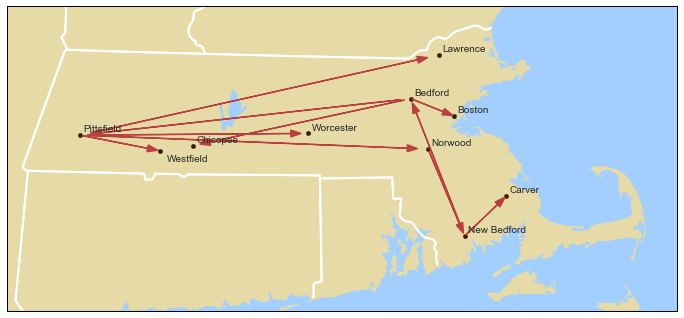

In [83]:
plt.figure(figsize=(12, 7))
plot_map_graph(k2_max3)

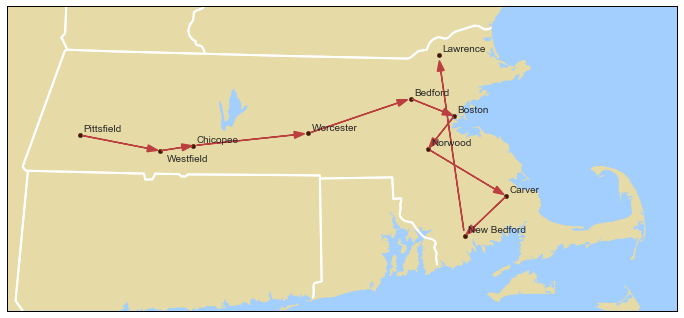

In [112]:
plt.figure(figsize=(12, 7))
plot_map_graph(ord_relation)

pebl merge end